In [20]:

import numpy as np
import scipy
from scipy import signal
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import pycbc.waveform
from pycbc.waveform import get_td_waveform
from pycbc.waveform import get_fd_waveform
from pycbc.psd import estimate
from pycbc.types import TimeSeries
import emcee
import corner
import time
from multiprocessing import Pool
from multiprocessing import cpu_count

In [2]:
ncpu = cpu_count()
print(ncpu)

12


# In the cell i am sorting the data to window and limit between 30-1000hz and defining psd to the right shape

In [3]:
# loading in data 
time_data, strain_data = np.loadtxt('data/PE_white_data_ts.txt',skiprows = 1).T
time_noise, strain_noise = np.loadtxt('data/PE_white_noise_ts.txt',skiprows=1).T


# converting to time series
strain_noise_ts = TimeSeries(strain_noise, delta_t = time_noise[1]-time_noise[0])
strain_data_ts = TimeSeries(strain_data,delta_t=time_data[1]-time_data[0])


# rolling to the middle and windowing and rolling back to 8 seconds
mid_point = len(strain_data) /2
final_point = len(strain_data)
peaks,_ = find_peaks(strain_data,height = 3e-21,distance = 1000)
roll_amount = mid_point - peaks
centred = np.roll(strain_data,int(roll_amount))
delta_t = time_data[1] - time_data[0]
window = signal.windows.hann(len(centred))
centred_windowed_signal = centred*window
centred_windowed_signal_final = np.roll(centred_windowed_signal,-int(roll_amount))


#defining main data and shaping
data_freq = np.fft.rfft(centred_windowed_signal_final) 
freq_array = np.fft.rfftfreq(len(time_data),delta_t)

delta_f = freq_array[1]-freq_array[0]

high_cutoff = 1000
low_cutoff = 30

high_limit = 800/delta_f+1
low_limit = 30/delta_f

data_final = data_freq[:int(high_limit)]
freq_final = freq_array[:int(high_limit)]

data_final[freq_final < low_cutoff] = 0 

#defing psd
delta_t = time_data[1] - time_data[0]
duration = len(strain_data)*delta_t
seg_len = len(strain_noise_ts) // 4
seg_stride = seg_len // 2

psd = estimate.welch(strain_noise_ts,window = 'hann' ,seg_len=seg_len,seg_stride = seg_stride)
psd_freqs = np.fft.fftfreq(len(psd), d=delta_t)  

interp_psd = interp1d(psd_freqs, psd, kind='linear', bounds_error=False, fill_value="extrapolate")
psd_interpolated = interp_psd(freq_array[:int(high_limit)]) 


In [4]:
# # loading in data 
# time_data, strain_data = np.loadtxt('data/PE_white_data_ts.txt',skiprows = 1).T
# time_noise, strain_noise = np.loadtxt('data/PE_white_noise_ts.txt',skiprows=1).T


# # converting to time series
# strain_noise_ts = TimeSeries(strain_noise, delta_t = time_noise[1]-time_noise[0])
# strain_data_ts = TimeSeries(strain_data,delta_t=time_data[1]-time_data[0])


# # rolling to the middle and windowing and rolling back to 8 seconds
# mid_point = len(strain_data) /2
# final_point = len(strain_data)
# peaks,_ = find_peaks(strain_data,height = 3e-21,distance = 1000)
# roll_amount = mid_point - peaks
# centred = np.roll(strain_data,int(roll_amount))
# delta_t = time_data[1] - time_data[0]
# window = signal.windows.hann(len(centred))
# centred_windowed_signal = centred*window



# #defining main data and shaping
# freq_array = np.fft.rfftfreq(len(time_data),delta_t)
# data_freq_test = np.fft.rfft(centred_windowed_signal)
# data_freq = np.fft.rfft(centred_windowed_signal)* np.exp(-2*np.pi*1j*freq_array*3)

# delta_f = freq_array[1]-freq_array[0]

# high_cutoff = 1000
# low_cutoff = 30

# high_limit = 1000/delta_f+1
# low_limit = 30/delta_f

# data_final = data_freq[:int(high_limit)]
# freq_final = freq_array[:int(high_limit)]
# # data_final = data_freq[int(low_limit):int(high_limit)]
# # freq_final = freq_array[int(low_limit):int(high_limit)]

# data_final[freq_final < 30] = 0 

# #defing psd

# delta_t = time_data[1] - time_data[0]
# duration = len(strain_data)*delta_t
# seg_len = len(strain_noise_ts) // 4
# seg_stride = seg_len // 2

# psd = estimate.welch(strain_noise_ts,window = 'hann' ,seg_len=seg_len,seg_stride = seg_stride)
# psd_freqs = np.fft.fftfreq(len(psd), d=delta_t)  

# interp_psd = interp1d(psd_freqs, psd, kind='linear', bounds_error=False, fill_value="extrapolate")
# # # psd_interpolated = interp_psd(freq_array[int(low_limit):int(high_limit)]) 

# psd_interpolated = interp_psd(freq_array[:int(high_limit)]) 
# print(len(freq_array))

# psd_hann = scipy.signal.windows.hann(1000)
# psd_hann = scipy.signal.welch(strain_noise, fs=1/delta_t, nperseg=1000, window=psd_hann)
# psd_freqs = np.fft.fftfreq(len(psd_hann), d=delta_t) 
# print(len(psd_freqs),len(psd_hann))
# interp_psd = interp1d(psd_freqs, psd_hann, kind='linear', bounds_error=False, fill_value="extrapolate")
# psd_interpolated = interp_psd(freq_array[:int(high_limit)]) 

/Users/maxrobertson/code/Grav Waves/venv/lib/python3.9/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/maxrobertson/code/Grav Waves/venv/lib/python3.9/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


[2.90342026e-47 3.36115163e-47 3.81888300e-47 ... 2.51258754e-47
 2.65011667e-47 2.78764580e-47]


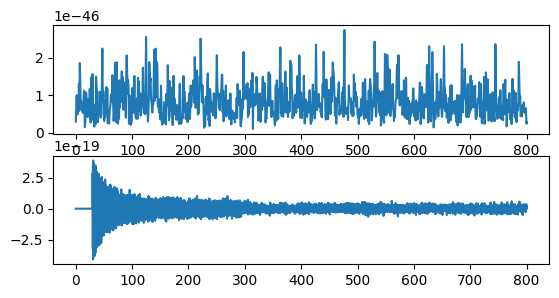

In [5]:
plt.subplot(311)
plt.plot(freq_final,psd_interpolated)
plt.subplot(312)
plt.plot(freq_final,data_final)

print(psd_interpolated)

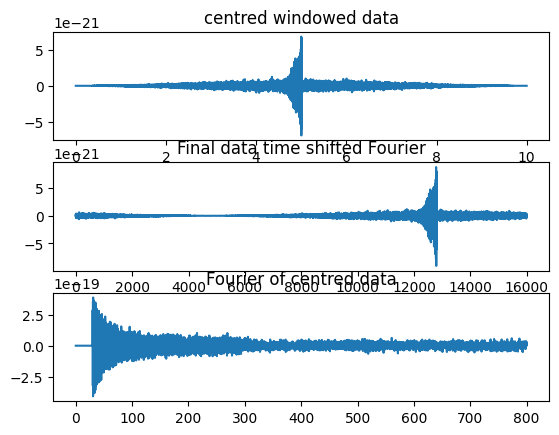

In [6]:
plt.subplot(311)
plt.plot(time_data,centred_windowed_signal)
plt.title('centred windowed data')
plt.subplot(312)
plt.plot(np.fft.irfft(data_final))
plt.title('Final data time shifted Fourier')
plt.subplot(313)
plt.title('Fourier of centred data')
plt.plot(freq_final,data_final)

# defining the template

In [7]:
def template(theta,delta_t,f_lower,f_higher,time_shift,delta_f):
    # M1,M2,D = theta 

    # hplus , hc = get_fd_waveform(mass1 = M1,mass2 = M2,distance = D,approximant='IMRPhenomPv2',f_lower=f_lower, f_higher=f_higher, delta_t = delta_t, delta_f = delta_f)

    # hplus_shifted= hplus.cyclic_time_shift(time_shift)
    
    # # hplus_cropped = hplus_shifted[int(low_limit):int(high_limit)]

    # # hplus_shifted= hplus * np.exp(-2*np.pi*1j*hplus.sample_frequencies*time_shift)


    # if len(hplus_shifted) > len(data_final):
    #     hplus_chop = hplus[:len(data_final)]
    #     # window_temp = signal.windows.hann(len(hplus_chop))
    #     # hplus_final = hplus_chop*window_temp
    #     # freq_chop = hplus.sample_frequencies[:len(data_final)]
    #     # window_temp = signal.windows.hann(len(hplus))
    #     # temp = hplus*window_temp
    #     # hplus_corrected= hplus_chop * np.exp(-2*np.pi*1j*freq_chop*time_shift)
    #     return hplus_chop
    
    # # below is code to fix it but dont think i should have it.
    # if len(hplus_shifted) == len(data_final):
    #     # hplus_corrected = hplus*np.exp(-2*np.pi*1j*hplus.sample_frequencies*time_shift)
    #     # window_temp = signal.windows.hann(len(hplus))
    #     # hplus = hplus_shifted*window_temp
    #     return hplus
    
    # if len(hplus_shifted) < len(data_final):
    #     pad_amount = len(data_final) - len(hplus)
    #     hplus_padded = np.pad(hplus,(0,pad_amount),'constant',constant_values=(0,0))
    #     # freq_padded = np.pad(hplus.sample_frequencies,(0,pad_amount),'constant',constant_values=(0,0))
    #     # window_temp = signal.windows.hann(len(hplus_padded))
    #     # hplus_final = hplus_padded*window_temp

    #     # hplus_corrected = hplus_padded * np.exp(-2*np.pi*1j*freq_padded*time_shift)
    #     return hplus_padded
    
    

IndentationError: expected an indented block (2410062792.py, line 40)

In [8]:

theta  = 33.999,33.9991,70.0001
temp = template(theta,delta_t,30,1000,8,delta_f)

print(len(temp))

NameError: name 'template' is not defined

In [9]:
def template(theta,delta_t,f_lower,f_higher,time_shift,delta_f):
    M1,M2,D = theta 

    hplus , hc = get_fd_waveform(mass1 = M1,mass2 = M2,distance = D,approximant='IMRPhenomPv2',f_lower=f_lower, f_higher=f_higher, delta_t = delta_t,delta_f = delta_f)
    # temp_cropped = hplus.crop(left = 4 , right = 2)
    # temp = np.fft.rfft(temp_cropped)

    hplus= hplus.cyclic_time_shift(time_shift)
    if len(hplus) > len(data_final):
        hplus = hplus[:len(data_final)]
        # window_temp = signal.windows.hann(len(hplus))
        # temp = hplus*window_temp
        return hplus
    
    # below is code to fix it but dont think i should have it.
    # if len(hplus) == len(data_final):
    #     return hplus
    
    # if len(hplus) < len(data_final):
    #     pad_amount = len(data_final) - len(hplus)
    #     hplus = np.pad(hplus,(0,pad_amount),'constant',constant_values=(0,0))
    #     return hplus

In [10]:
# theta = 31,28.1,71
# temp = template(theta, delta_t,30,1024,8,delta_f)

# plt.plot((temp))
# # plt.plot(data_final)
# # d_t = (temp.sample_times[1] - temp.sample_times[0])
# # print(len(temp.sample_times)/d_t)
# # print(67108864/18)

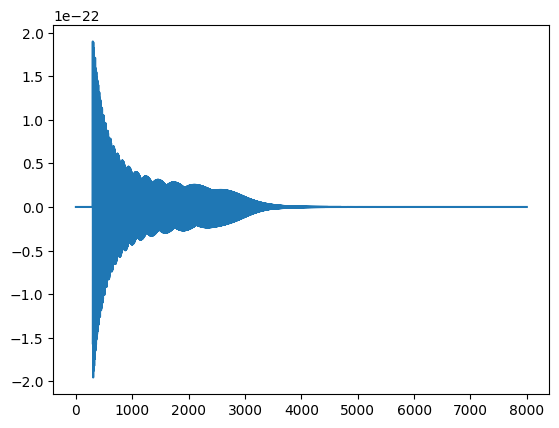

8001
8001


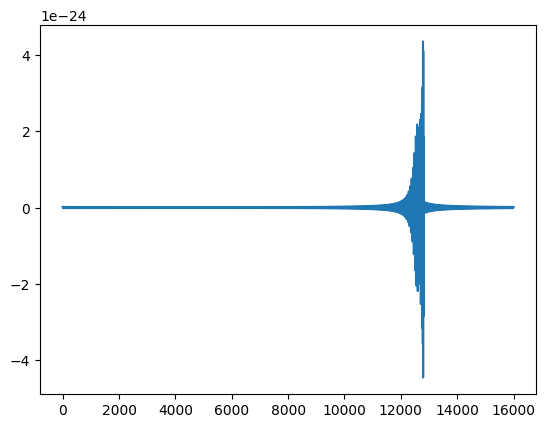

In [11]:
# 33.53802112  33.46240316 112.41767687]
theta = 32,30, 100
# time = np.linspace(0,10,20000)
temp = template(theta,delta_t, 30, 1024, 8 , delta_f)

N = len(temp)

time = np.fft.fftfreq(N, d=delta_f)

plt.plot((temp))
plt.show()
plt.plot((np.fft.irfft(temp)))
print(len(temp))
print(len(data_final))

In [12]:
# theta = 32    
# delta_f = 1/(len(time_data)*delta_t)
# hplus , hc = get_fd_waveform(mass1 = 40,mass2 = 30,distance = 1024,approximant='IMRPhenomPv2',f_lower=30, f_higher=1000, delta_t = delta_t, delta_f = 0.08)

# temp = template(theta, delta_t,30,1024,8)
# print(temp)
# plt.plot(temp)

# Defining the prior in log space

In [13]:
def log_prior(theta):
    M1,M2,D = theta
    
    if not (30 < M1 < 34):
        return -np.inf 
    
    if not (28 < M2 < M1):
        return -np.inf
    
    if not(70 < D < 120):
        return -np.inf
    
    return 0.0 + np.log(D)


# Defining the log likelihood function

In [14]:
def log_like(theta, fft_signal,noise ,delta_t,delta_f):

    
    temp = template(theta, delta_t , 30, 1024,8,delta_f)

    residual = fft_signal*delta_t - temp*delta_t
    sum = np.abs(residual)**2/noise
    return -2 / 10 * np.sum((sum).numpy())

# Defining the log posterior

In [15]:
def log_posterior(theta, data,noise_data,delta_t,delta_f):
    # print(f"Theta: {theta}")
    log_pri = log_prior(theta)
    if np.isinf(log_pri):  # if prior is -inf, return stragiht away
        return log_pri
    return log_pri + log_like(theta, data, noise_data,delta_t,delta_f)

In [16]:
theta = 32,30,100
print((log_prior(theta)))
print(log_posterior(theta,data_final,psd_interpolated,delta_t,delta_f))

print((9.2103 - 30416))

4.605170185988092
-30421.335278832936
-30406.7897


# running the mcmc

In [17]:
# nwalkers = 30
# ndim = 3

# initial = np.empty((nwalkers, ndim)) 
# initial[:, 0] = np.random.uniform(30, 34, size=nwalkers)
# initial[:, 1] = np.random.uniform(28, initial[:, 0])
# initial[:, 2] = np.random.uniform(80, 150, size=nwalkers)

# with Pool() as pool:
#     sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior,args = (data_final,psd_interpolated,delta_t,delta_f), pool=pool)
#     start = time.time()
#     sampler.run_mcmc(initial, 2000, progress=True)
#     sampler.reset()
#     # running the mcmc
#     nsteps = 2000
#     sampler.run_mcmc(initial, nsteps,progress = True)
#     end = time.time()
#     multi_time = end - start


# main mcmc run

In [18]:
# defining the number of walkers in the mcmc chain and th number of dimensions (parameters)
nwalkers = 10
ndim = 3

# defining intitial array of guess (theta guesses)
initial = np.empty((nwalkers, ndim)) 
initial[:, 0] = np.random.uniform(30, 34, size=nwalkers)
initial[:, 1] = np.random.uniform(28, initial[:, 0])
initial[:, 2] = np.random.uniform(70, 120, size=nwalkers)


#running the emcee sampelr
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(data_final,psd_interpolated,delta_t,delta_f))#,moves= emcee.moves.StretchMove())

#running the burn - in stage of the mcmc chain to allow the walker tp explore the space
state = sampler.run_mcmc(initial, nsteps = 500,progress = True)
sampler.reset()
# running the mcmc

nsteps = 500
sampler.run_mcmc(initial, nsteps,progress = True)

100%|██████████| 500/500 [00:46<00:00, 10.78it/s]


State([[32.5171756  30.02275112 70.22104551]
 [32.90575129 29.82278546 72.40051391]
 [32.9445282  28.86814838 72.54879491]
 [31.52116391 30.84966219 71.46081256]
 [32.85227155 29.22432968 70.69629125]
 [33.64093859 28.63783861 75.00288425]
 [32.50976995 30.11542    70.97872577]
 [32.42191995 29.59005563 71.13660244]
 [31.5873307  30.54578799 70.15545578]
 [32.36031662 29.95595806 73.27451532]], log_prob=[-30411.65790409 -30413.77214615 -30411.99076614 -30411.49204433
 -30411.09807769 -30414.21476842 -30412.33532448 -30411.1398369
 -30410.55556141 -30412.46471065], blobs=None, random_state=('MT19937', array([ 932414127, 1435230703, 1683472215, 2121096161, 2951136222,
       2053930579, 2593265106, 1439616914,  498110058, 2660123502,
        193433995, 3769873206, 3004950323, 1923559442, 1304985970,
       1774156500, 2666627118,  525363959,  626848171,  533528253,
        481657679, 1743547529, 1376047112, 4227618744, 3390924864,
       1987885148, 2420075028, 2101709125, 1411442442, 22

# plotting the mcmc results

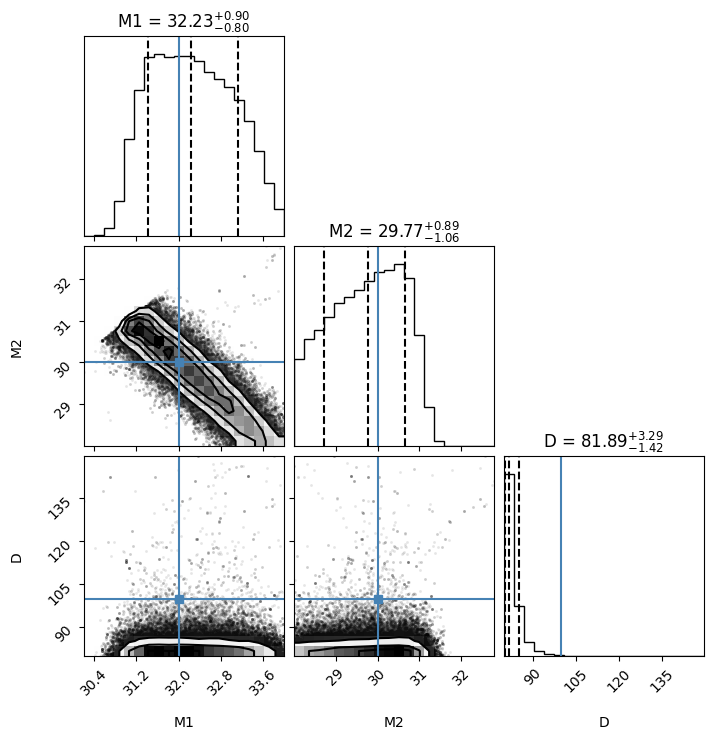

In [16]:
# this was 10 walkers, 1500 burn in, and 500 steps
samples = sampler.flatchain
# samples = sampler.get_chain(flat=True)
# samples = sampler.get_chain()

figure = corner.corner(samples,labels = ['M1','M2','D'],quantiles=[0.16,0.5,0.84],truths = [32,30,100],show_titles = True)

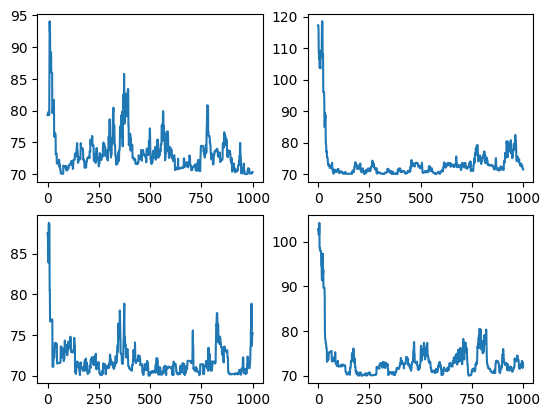

In [84]:
samples = sampler.get_chain()


plt.subplot(221)
plt.plot(samples[:,4,2])
plt.subplot(222)
plt.plot(samples[:,3,2])
plt.subplot(223)
plt.plot(samples[:,2,2])
plt.subplot(224)
plt.plot(samples[:,1,2])



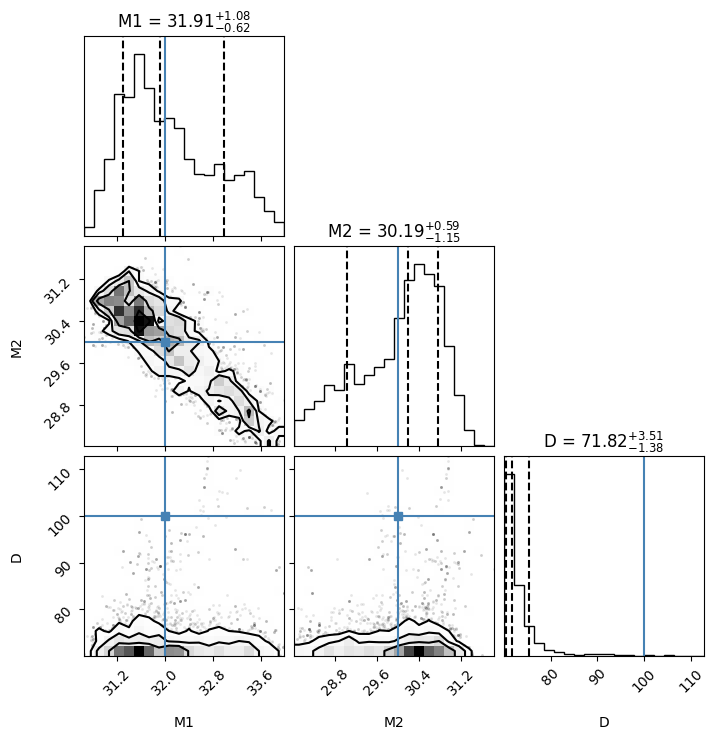

In [19]:
# this was 10 walkers, 1500 burn in, and 500 steps
samples = sampler.flatchain
# samples = sampler.get_chain(flat=True)
# samples = sampler.get_chain()

figure = corner.corner(samples,labels = ['M1','M2','D'],quantiles=[0.16,0.5,0.84],truths = [32,30,100],show_titles = True)